In [1]:
import pandas as pd
import numpy as np

In [3]:
hn_daily = pd.read_csv('../dataset/raw/Hanoi Daily.csv')
hn_daily.head()

,name,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,...,solarenergy,uvindex,severerisk,sunrise,sunset,moonphase,conditions,description,icon,stations
0,Hanoi,2015-01-01,24.0,11.4,17.7,24.0,11.4,17.7,9.4,63.8,...,17.1,7,NaN,2015-01-01T06:33:34,2015-01-01T17:26:18,0.36,Clear,Clear conditions throughout the day.,clear-day,"48820099999,48823099999,48825099999,4883109999..."
1,Hanoi,2015-01-02,22.0,11.0,16.3,22.0,11.0,16.3,9.4,65.6,...,16.2,7,NaN,2015-01-02T06:33:53,2015-01-02T17:26:56,0.39,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"48820099999,48823099999,48825099999,4883109999..."
2,Hanoi,2015-01-03,21.0,13.1,17.0,21.0,13.1,17.0,12.4,75.6,...,9.9,4,NaN,2015-01-03T06:34:11,2015-01-03T17:27:34,0.43,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"48820099999,48823099999,48825099999,4883109999..."
3,Hanoi,2015-01-04,22.6,16.9,19.3,22.6,16.9,19.3,16.1,82.0,...,5.6,3,NaN,2015-01-04T06:34:28,2015-01-04T17:28:12,0.46,"Rain, Partially cloudy",Partly cloudy throughout the day with a chance...,rain,"48820099999,48823099999,48825099999,4883109999..."
4,Hanoi,2015-01-05,23.0,18.5,20.4,23.0,18.5,20.4,18.4,88.4,...,7.9,4,NaN,2015-01-05T06:34:44,2015-01-05T17:28:51,0.50,Overcast,Cloudy skies throughout the day.,cloudy,"48820099999,48823099999,48825099999,4883109999..."


In [4]:
hn_daily['datetime'] = pd.to_datetime(hn_daily['datetime'])

In [5]:
# Chia train-test split theo thời gian, trong đó khoảng cách tập train và test là 7 ngày để tránh data leakage do tính chất thời gian của dữ liệu, temp là biến mục tiêu
def tran_val_test_split(df, train_ratio, val_ratio):
    train_size = int(len(hn_daily) * train_ratio)
    val_size = int(len(hn_daily) * val_ratio)

    
    train_data = hn_daily.iloc[:train_size]
    val_data = hn_daily.iloc[train_size:train_size + val_size]
    test_data = hn_daily.iloc[train_size + val_size:]
    
    print(f"Kích thước tập huấn luyện: {train_data.shape}")
    print(f"Kích thước tập kiểm tra: {test_data.shape}")
    print(f"Kích thước tập validation: {val_data.shape}")
    print(f"Khoảng thời gian tập huấn luyện: {train_data['datetime'].min()} đến {train_data['datetime'].max()}")
    print(f"Khoảng thời gian tập validation: {val_data['datetime'].min()} đến {val_data['datetime'].max()}")
    print(f"Khoảng thời gian tập kiểm tra: {test_data['datetime'].min()} đến {test_data['datetime'].max()}")

    # temp là biến mục tiêu
    feature_cols = hn_daily.columns.drop(['temp', 'datetime'])  # Loại bỏ cột temp khỏi features
    X_train = train_data[feature_cols]
    y_train = train_data['temp']
    X_val = val_data[feature_cols]
    y_val = val_data['temp']
    X_test = test_data[feature_cols]
    y_test = test_data['temp']

    print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
    print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
    return X_train, y_train, X_val, y_val, X_test, y_test

In [ ]:
X_train

In [214]:

# FUNCTION: FEATURE ENGINEERING PIPELINE
# ============================================

def create_features(df, is_train=True, is_val=False):
    """
    Tạo features cho dữ liệu Hà Nội (khí hậu gió mùa)
    
    Parameters:
    -----------
    df : DataFrame
        DataFrame chứa dữ liệu gốc (train hoặc test)
    is_train : bool
        True nếu là training set (để fit transform), False nếu là test set
        
    Returns:
    --------
    X : DataFrame
        Features đã được engineering
    y : Series
        Target variable (temp)
    """
    
    df = df.copy()
    
    # Tách target
    y = df['temp'].copy()
    
    # Loại bỏ cột không dùng
    X = df.drop(['temp', 'datetime', 'name', 'stations', 'feelslike', 'feelslikemax', 'feelslikemin', 'description', 'icon', 'solarenergy', 'severerisk', 'visibility', 'moonphase', 'uvindex'], axis=1, errors='ignore')
    
    print(f"\n{'='*60}")
    print(f"{'TRAINING SET' if is_train else 'VALIDATION SET' if is_val else 'TEST SET'} - Feature Engineering")
    print(f"{'='*60}")
    print(f"Initial shape: {X.shape}")
    
    # 1. BASIC CLEANING
    
    # Drop columns with all missing or constant values
    cols_to_drop = []
    for col in X.columns:
        if X[col].isna().all() or X[col].nunique() <= 1:
            cols_to_drop.append(col)
    
    if cols_to_drop:
        X = X.drop(columns=cols_to_drop)
        print(f"\nDropped {len(cols_to_drop)} constant/empty columns: {cols_to_drop}")
    

    # ============================================
    # 2. TEMPORAL FEATURES (OPTIMIZED & CLEAN)
    # ============================================

    datetime_col = df['datetime']
    # Extract base temporal info (DO NOT add to X yet)
    month = datetime_col.dt.month
    X['month'] = month
    day_of_year = datetime_col.dt.dayofyear
    X['day_of_year'] = day_of_year

    # ========================================
    # LEVEL 1: Cyclical Encoding (Core)
    # ========================================
    # Best for capturing smooth seasonal patterns
    X['month_sin'] = np.sin(2 * np.pi * month / 12)
    X['month_cos'] = np.cos(2 * np.pi * month / 12)
    X['day_sin'] = np.sin(2 * np.pi * day_of_year / 365.25)
    X['day_cos'] = np.cos(2 * np.pi * day_of_year / 365.25)

    # ========================================
    # LEVEL 2: Week Patterns
    # ========================================
    # Useful for weekly weather cycles
    X['day_of_week'] = datetime_col.dt.dayofweek

    # ========================================
    # LEVEL 3: Season (Domain-Specific)
    # ========================================
    # Captures Hanoi's 4 distinct seasons
    def get_season_hanoi(m):
        if m in [11, 12, 1, 2]: return 0  # Winter (cold, dry)
        elif m in [3, 4, 5]: return 1      # Spring (warm)
        elif m in [6, 7, 8]: return 2      # Summer (hot, rainy)
        else: return 3                      # Fall (cool)

    X['season'] = month.apply(get_season_hanoi)

    # ========================================
    # LEVEL 4: Monsoon Indicators (Critical)
    # ========================================
    # Most important for Hanoi weather prediction
    X['is_summer_monsoon_season'] = month.isin([5, 6, 7, 8, 9]).astype(int)
    X['is_winter_monsoon_season'] = month.isin([11, 12, 1, 2, 3]).astype(int)
    X['is_transition_season'] = month.isin([4, 10]).astype(int)

    # ========================================
    # LEVEL 5: Peak Indicators (Bonus)
    # ========================================
    # High signal-to-noise ratio
    X['is_peak_summer'] = month.isin([7, 8]).astype(int)
    X['is_peak_winter'] = month.isin([1, 2]).astype(int)
    X['is_rainiest_month'] = month.isin([7, 8, 9]).astype(int)

    print(f"✅ Temporal features: +13 features")
    
    # ============================================
    # 3. SOLAR FEATURES
    # ============================================
    
    if 'sunrise' in df.columns and 'sunset' in df.columns:
        sunrise_dt = pd.to_datetime(df['sunrise'])
        sunset_dt = pd.to_datetime(df['sunset'])
        
        X['day_length_hours'] = (sunset_dt - sunrise_dt).dt.total_seconds() / 3600
        X['sunrise_hour'] = sunrise_dt.dt.hour + sunrise_dt.dt.minute / 60
        X['sunset_hour'] = sunset_dt.dt.hour + sunset_dt.dt.minute / 60
        X['solar_noon'] = (X['sunrise_hour'] + X['sunset_hour']) / 2
        X['solar_declination'] = 23.45 * np.sin(2 * np.pi * (X['day_of_year'] - 81) / 365)
        X['day_length_change'] = X['day_length_hours'].diff().fillna(0)
        
        # Drop original sunrise/sunset
        X = X.drop(['sunrise', 'sunset'], axis=1, errors='ignore')
        print(f"✅ Solar features: +4 features")
    
    # ============================================
    # 4. WIND/MONSOON FEATURES
    # ============================================
    
    if 'winddir' in X.columns and 'windspeed' in X.columns:
        winddir_rad = X['winddir'] * np.pi / 180
        
        # Vector components of windspeed and direction
        X['wind_u'] = X['windspeed'] * np.sin(winddir_rad)
        X['wind_v'] = X['windspeed'] * np.cos(winddir_rad)
        
        X['is_northeast_wind'] = ((X['winddir'] >= 0) & (X['winddir'] <= 90)).astype(int)
        X['is_southwest_wind'] = ((X['winddir'] >= 180) & (X['winddir'] <= 270)).astype(int)
        
        # Monsoon alignment
        def get_monsoon_alignment(winddir, month):
            if month in [11, 12, 1, 2, 3]:
                deviation = abs(winddir - 45) if winddir <= 180 else abs(360 - winddir + 45)
                return max(0, 1 - deviation / 180)
            elif month in [5, 6, 7, 8, 9]:
                deviation = abs(winddir - 225)
                return max(0, 1 - deviation / 180)
            else:
                return 0.5
        
        X['monsoon_alignment'] = X.apply(
            lambda row: get_monsoon_alignment(row['winddir'], row['month']), axis=1
        )

        X['summer_monsoon_intensity'] = (X['windspeed'] * X['monsoon_alignment'] * X['is_summer_monsoon_season'])
        X['winter_monsoon_intensity'] = (X['windspeed'] * X['monsoon_alignment'] * X['is_winter_monsoon_season'])

        drop_cols = ['winddir', 'windspeed']
        X = X.drop(columns=drop_cols, errors='ignore')

        print(f"✅ Wind/Monsoon features: +8 features")
    
    # ============================================
    # 5. INTERACTION FEATURES
    # ============================================
    
    if 'sealevelpressure' in X.columns:
        X['pressure_change_1d'] = X['sealevelpressure'].diff(1).fillna(0)
        X['pressure_change_3d'] = X['sealevelpressure'].diff(3).fillna(0)
    
    if 'precipprob' in X.columns and 'precipcover' in X.columns:
        X['precip_risk_score'] = X['precipprob'] * X['precipcover'] / 10000
    
    if 'solarradiation' in X.columns and 'cloudcover' in X.columns:
        X['solar_efficiency'] = np.where(X['cloudcover'] > 0, X['solarradiation'] / (100 - X['cloudcover'] + 1), X['solarradiation'])
    
    drop_col = ['precipprob', 'precipcover', 'sealevelpressure']
    X = X.drop(columns=drop_col, errors='ignore')
    
    print(f"✅ Interaction features: +3 features")
    
    # ============================================
    # 6. DERIVED WEATHER INDICATORS
    # ============================================
    
    if 'cloudcover' in X.columns:
        X['cloudcover_change'] = X['cloudcover'].diff().fillna(0)
        X['is_clear_sky'] = (X['cloudcover'] < 20).astype(int)
        X['is_overcast'] = (X['cloudcover'] > 80).astype(int)
    
    if 'precip' in X.columns:
        precip_threshold = X['precip'].quantile(0.9)
        X['is_heavy_rain'] = (X['precip'] > precip_threshold).astype(int)
    
    print(f"✅ Derived indicators: +4 features")
    
    # ============================================
    # 7. LAG FEATURES
    
    # if 'tempmax' in X.columns and 'tempmin' in X.columns:
    #     # for lag in [1, 2, 3, 7, 14]:
    #     #     X[f'tempmax_lag_{lag}'] = X['tempmax'].shift(lag)
    #     #     X[f'tempmin_lag_{lag}'] = X['tempmin'].shift(lag)
    
    #     for window in [3, 7, 14, 30, 60, 90]:
    #         X[f'temp_rolling_mean_{window}'] = X['tempmax'].rolling(window).mean()
    #         X[f'temp_rolling_std_{window}'] = X['tempmax'].rolling(window).std()
    #         X[f'temp_rolling_min_{window}'] = X['tempmin'].rolling(window).min()
    #         X[f'temp_rolling_max_{window}'] = X['tempmax'].rolling(window).max()
    
    if 'humidity' in X.columns:
        X['humidity_lag_1'] = X['humidity'].shift(1)  # Chỉ 1 ngày trước
        X['humidity_rolling_mean_7'] = X['humidity'].rolling(7).mean()

    if 'precip' in X.columns:
        X['precip_lag_1'] = X['precip'].shift(1)
        X['precip_sum_7'] = X['precip'].rolling(7).sum()
        
        print(f"✅ Lag/Rolling features: +50 features")
    
    # ============================================
    # 8. SEASONAL ANOMALY FEATURES
    # ============================================
    
    # if 'tempmax_lag_1' in X.columns:
    #     X['temp_seasonal_mean'] = X.groupby('season')['tempmax_lag_1'].transform('mean')
    #     X['temp_anomaly'] = X['tempmax_lag_1'] - X['temp_seasonal_mean']
    
    if 'humidity_lag_1' in X.columns:
        X['humidity_seasonal_mean'] = X.groupby('season')['humidity_lag_1'].transform('mean')
        X['humidity_anomaly'] = X['humidity_lag_1'] - X['humidity_seasonal_mean']
    
    if 'pressure_lag_1' in X.columns:
        X['pressure_baseline'] = X['pressure_lag_1'].rolling(30, min_periods=1).mean()
        X['pressure_anomaly'] = X['pressure_lag_1'] - X['pressure_baseline']
    
    print(f"✅ Anomaly features: +6 features")
    
    
    drop_cols = ['month', 'day_of_year', 'tempmax', 'tempmin']
    X = X.drop(columns=drop_cols, errors='ignore')
    print(f"\n📊 Final shape: {X.shape}")
    print(f"📊 Missing values: {X.isna().sum().sum()} total")
    print(f"   - Rows with NaN: {X.isna().any(axis=1).sum()}")
    
    return X, y

print("✅ Feature engineering function defined!")

✅ Feature engineering function defined!


In [215]:
# ============================================
# APPLY FEATURE ENGINEERING TO TRAIN SET
# ============================================

X_train, y_train = create_features(train_df, is_train=True)

print("\n" + "="*60)
print("✅ TRAIN SET FEATURE ENGINEERING COMPLETED")
print("="*60)


TRAINING SET - Feature Engineering
Initial shape: (2658, 19)

Dropped 3 constant/empty columns: ['preciptype', 'snow', 'snowdepth']
✅ Temporal features: +13 features
✅ Solar features: +4 features
✅ Wind/Monsoon features: +8 features
✅ Interaction features: +3 features
✅ Derived indicators: +4 features
✅ Lag/Rolling features: +50 features
✅ Anomaly features: +6 features

📊 Final shape: (2658, 46)
📊 Missing values: 15 total
   - Rows with NaN: 6

✅ TRAIN SET FEATURE ENGINEERING COMPLETED


In [216]:
# APPLY FEATURE ENGINEERING TO VAL SET
X_val, y_val = create_features(val_df, is_train=False, is_val=True)
print("\n" + "="*60)
print("✅ VALIDATION SET FEATURE ENGINEERING COMPLETED")
print("="*60)


VALIDATION SET - Feature Engineering
Initial shape: (499, 19)

Dropped 3 constant/empty columns: ['preciptype', 'snow', 'snowdepth']
✅ Temporal features: +13 features
✅ Solar features: +4 features
✅ Wind/Monsoon features: +8 features
✅ Interaction features: +3 features
✅ Derived indicators: +4 features
✅ Lag/Rolling features: +50 features
✅ Anomaly features: +6 features

📊 Final shape: (499, 46)
📊 Missing values: 15 total
   - Rows with NaN: 6

✅ VALIDATION SET FEATURE ENGINEERING COMPLETED


In [217]:
# ============================================
# APPLY FEATURE ENGINEERING TO TEST SET
# ============================================

X_test, y_test = create_features(test_df, is_train=False, is_val=False)

print("\n" + "="*60)
print("✅ TEST SET FEATURE ENGINEERING COMPLETED")
print("="*60)


TEST SET - Feature Engineering
Initial shape: (590, 19)

Dropped 3 constant/empty columns: ['preciptype', 'snow', 'snowdepth']
✅ Temporal features: +13 features
✅ Solar features: +4 features
✅ Wind/Monsoon features: +8 features
✅ Interaction features: +3 features
✅ Derived indicators: +4 features
✅ Lag/Rolling features: +50 features
✅ Anomaly features: +6 features

📊 Final shape: (590, 46)
📊 Missing values: 15 total
   - Rows with NaN: 6

✅ TEST SET FEATURE ENGINEERING COMPLETED


In [218]:
# ============================================
# HANDLE MISSING VALUES FROM LAG FEATURES
# ============================================

print("="*60)
print("HANDLING MISSING VALUES")
print("="*60)

# Check missing values
print(f"\n📊 Train set:")
print(f"   Before: {X_train.shape}")
print(f"   Rows with NaN: {X_train.isna().any(axis=1).sum()}")
print(f"   Missing per column (top 10):")
missing_train = X_train.isna().sum()
print(missing_train[missing_train > 0].sort_values(ascending=False).head(10))

print(f"\n📊 Test set:")
print(f"   Before: {X_test.shape}")
print(f"   Rows with NaN: {X_test.isna().any(axis=1).sum()}")

# Drop rows with NaN (mainly from lag features)
X_train_final = X_train.dropna()
y_train_final = y_train.loc[X_train_final.index]

X_test_final = X_test.dropna()
y_test_final = y_test.loc[X_test_final.index]

print(f"\n✅ After dropping NaN:")
print(f"   Train: {X_train_final.shape}, y_train: {y_train_final.shape}")
print(f"   Test:  {X_test_final.shape}, y_test:  {y_test_final.shape}")

# Verify no missing values
assert X_train_final.isna().sum().sum() == 0, "Train still has NaN!"
assert X_test_final.isna().sum().sum() == 0, "Test still has NaN!"

print(f"\n✅ Data ready for GBDT models!")
print("="*60)

HANDLING MISSING VALUES

📊 Train set:
   Before: (2658, 46)
   Rows with NaN: 6
   Missing per column (top 10):
humidity_rolling_mean_7    6
precip_sum_7               6
humidity_lag_1             1
precip_lag_1               1
humidity_anomaly           1
dtype: int64

📊 Test set:
   Before: (590, 46)
   Rows with NaN: 6

✅ After dropping NaN:
   Train: (2652, 46), y_train: (2652,)
   Test:  (584, 46), y_test:  (584,)

✅ Data ready for GBDT models!


In [219]:
# ============================================
# ENCODE CHO CÁC MODEL KHÁC NHAU
# ============================================

print("="*80)
print("🔤 CATEGORICAL FEATURE ENCODING STRATEGY")
print("="*80)

# 1. Kiểm tra categorical features
if 'conditions' in X_train_final.columns:
    print(f"\n📊 Found 'conditions' feature")
    print(f"   Unique values: {X_train_final['conditions'].nunique()}")
    
    # ========================================
    # STRATEGY A: Encode cho RF, XGB, LGB, GB
    # ========================================
    print("\n🔹 Creating encoded versions for RF/XGB/LGB/GB...")
    
    X_train_encoded = X_train_final.copy()
    X_test_encoded = X_test_final.copy()
    
    # Label Encoding
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    
    X_train_encoded['conditions'] = le.fit_transform(X_train_encoded['conditions'].astype(str))
    X_test_encoded['conditions'] = X_test_encoded['conditions'].astype(str).map(
        lambda x: le.transform([x])[0] if x in le.classes_ else -1
    )
    
    print(f"   ✅ Encoded 'conditions': {len(le.classes_)} categories")
    
    # ========================================
    # STRATEGY B: Giữ nguyên cho CatBoost
    # ========================================
    print("\n🔹 Keeping raw categorical for CatBoost...")
    
    X_train_catboost = X_train_final.copy()
    X_test_catboost = X_test_final.copy()
    
    # Đảm bảo 'conditions' là string type
    X_train_catboost['conditions'] = X_train_catboost['conditions'].astype(str)
    X_test_catboost['conditions'] = X_test_catboost['conditions'].astype(str)
    
    print(f"   ✅ Kept raw 'conditions' for CatBoost")
    print(f"   Train shape: {X_train_catboost.shape}")
    print(f"   Test shape: {X_test_catboost.shape}")

else:
    print("\n⚠️  'conditions' feature not found")
    X_train_encoded = X_train_final.copy()
    X_test_encoded = X_test_final.copy()
    X_train_catboost = X_train_final.copy()
    X_test_catboost = X_test_final.copy()

print("\n" + "="*80)

🔤 CATEGORICAL FEATURE ENCODING STRATEGY

📊 Found 'conditions' feature
   Unique values: 6

🔹 Creating encoded versions for RF/XGB/LGB/GB...
   ✅ Encoded 'conditions': 6 categories

🔹 Keeping raw categorical for CatBoost...
   ✅ Kept raw 'conditions' for CatBoost
   Train shape: (2652, 46)
   Test shape: (584, 46)



In [220]:
X_train_final.columns.tolist()

['dew',
 'humidity',
 'precip',
 'windgust',
 'cloudcover',
 'solarradiation',
 'conditions',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'day_of_week',
 'season',
 'is_summer_monsoon_season',
 'is_winter_monsoon_season',
 'is_transition_season',
 'is_peak_summer',
 'is_peak_winter',
 'is_rainiest_month',
 'day_length_hours',
 'sunrise_hour',
 'sunset_hour',
 'solar_noon',
 'solar_declination',
 'day_length_change',
 'wind_u',
 'wind_v',
 'is_northeast_wind',
 'is_southwest_wind',
 'monsoon_alignment',
 'summer_monsoon_intensity',
 'winter_monsoon_intensity',
 'pressure_change_1d',
 'pressure_change_3d',
 'precip_risk_score',
 'solar_efficiency',
 'cloudcover_change',
 'is_clear_sky',
 'is_overcast',
 'is_heavy_rain',
 'humidity_lag_1',
 'humidity_rolling_mean_7',
 'precip_lag_1',
 'precip_sum_7',
 'humidity_seasonal_mean',
 'humidity_anomaly']

In [196]:
# ============================================
# FEATURE SUMMARY
# ============================================

print("="*80)
print("🎯 FINAL FEATURE ENGINEERING SUMMARY")
print("="*80)

print(f"\n📊 Dataset Sizes:")
print(f"   Train: {X_train_final.shape[0]} samples × {X_train_final.shape[1]} features")
print(f"   Test:  {X_test_final.shape[0]} samples × {X_test_final.shape[1]} features")

print(f"\n📋 Feature Categories:")
feature_groups = {
    'Temporal': ['month', 'day', 'week', 'quarter', 'season'],
    'Solar': ['solar', 'day_length', 'sunrise', 'sunset'],
    'Wind/Monsoon': ['wind', 'monsoon'],
    'Interaction': ['interaction', 'index', 'chill', 'intensity'],
    'Lag/Rolling': ['lag', 'rolling'],
    'Anomaly': ['anomaly', 'baseline'],
    'Derived': ['dewpoint', 'vpd', 'is_clear', 'is_heavy', 'is_overcast'],
    'Categorical': ['conditions']
}

for group_name, keywords in feature_groups.items():
    count = len([c for c in X_train_final.columns if any(k in c for k in keywords)])
    print(f"   {group_name:15s}: {count:3d} features")

print(f"\n✅ Key Features for Monsoon Climate:")
monsoon_features = [
    'is_monsoon_season', 'is_dry_season', 
    'is_northeast_wind', 'is_southwest_wind', 'monsoon_alignment', 'monsoon_intensity',
    'season', 'heat_index_approx', 'wind_chill'
]
available = [f for f in monsoon_features if f in X_train_final.columns]
print(f"   {len(available)}/{len(monsoon_features)} monsoon-specific features available")
for f in available:
    print(f"      ✓ {f}")

print("\n" + "="*80)
print("✅ FEATURE ENGINEERING COMPLETED - READY FOR MODEL TRAINING!")
print("="*80)

🎯 FINAL FEATURE ENGINEERING SUMMARY

📊 Dataset Sizes:
   Train: 3045 samples × 46 features
   Test:  780 samples × 46 features

📋 Feature Categories:
   Temporal       :  13 features
   Solar          :   8 features
   Wind/Monsoon   :  10 features
   Interaction    :   2 features
   Lag/Rolling    :   3 features
   Anomaly        :   1 features
   Derived        :   3 features
   Categorical    :   1 features

✅ Key Features for Monsoon Climate:
   4/9 monsoon-specific features available
      ✓ is_northeast_wind
      ✓ is_southwest_wind
      ✓ monsoon_alignment
      ✓ season

✅ FEATURE ENGINEERING COMPLETED - READY FOR MODEL TRAINING!


In [197]:
# ============================================
# IMPORT GBDT LIBRARIES
# ============================================

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# pip install xgboost lighgbm
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [198]:
# ============================================
# EVALUATION METRICS FUNCTION
# ============================================

def evaluate_model(y_true, y_pred, dataset_name="Dataset"):
    """
    Đánh giá hiệu suất mô hình với các metrics phổ biến
    
    Parameters:
    -----------
    y_true : array-like
        Giá trị thực tế
    y_pred : array-like
        Giá trị dự đoán
    dataset_name : str
        Tên của dataset (Train/Test)
        
    Returns:
    --------
    metrics : dict
        Dictionary chứa các metrics
    """
    
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    # MAPE (Mean Absolute Percentage Error)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    metrics = {
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'MAPE': mape
    }
    
    print(f"\n📊 {dataset_name} Performance:")
    print(f"   RMSE: {rmse:.4f}°C")
    print(f"   MAE:  {mae:.4f}°C")
    print(f"   R²:   {r2:.4f}")
    print(f"   MAPE: {mape:.2f}%")
    
    return metrics

print("✅ Evaluation function defined!")

✅ Evaluation function defined!


In [ ]:
# ============================================
# OVERFITTING CHECK FUNCTION
# ============================================

def check_overfitting(train_metrics, test_metrics, model_name="Model"):
    """
    Kiểm tra overfitting bằng cách so sánh performance giữa train và test
    
    Parameters:
    -----------
    train_metrics : dict
        Metrics từ tập train
    test_metrics : dict
        Metrics từ tập test
    model_name : str
        Tên mô hình
        
    Returns:
    --------
    overfitting_report : dict
        Báo cáo về overfitting
    """
    
    print(f"\n{'='*60}")
    print(f"🔍 OVERFITTING ANALYSIS - {model_name}")
    print(f"{'='*60}")
    
    overfitting_report = {}
    
    for metric in ['RMSE', 'MAE', 'R2', 'MAPE']:
        train_val = train_metrics[metric]
        test_val = test_metrics[metric]
        
        if metric == 'R2':
            # For R2, higher is better
            diff = train_val - test_val
            diff_pct = (diff / train_val) * 100 if train_val != 0 else 0
        else:
            # For RMSE, MAE, MAPE, lower is better
            diff = test_val - train_val
            diff_pct = (diff / train_val) * 100 if train_val != 0 else 0
        
        overfitting_report[metric] = {
            'train': train_val,
            'test': test_val,
            'difference': diff,
            'difference_pct': diff_pct
        }
        
        print(f"\n{metric}:")
        print(f"   Train: {train_val:.4f}")
        print(f"   Test:  {test_val:.4f}")
        print(f"   Diff:  {diff:+.4f} ({diff_pct:+.2f}%)")
    
    # Overall overfitting assessment
    print(f"\n{'='*60}")
    r2_drop = overfitting_report['R2']['difference_pct']
    rmse_increase = overfitting_report['RMSE']['difference_pct']
    
    if r2_drop > 10 or rmse_increase > 20:
        status = "⚠️  SEVERE OVERFITTING DETECTED"
        color = "red"
    elif r2_drop > 5 or rmse_increase > 10:
        status = "⚠️  MODERATE OVERFITTING"
        color = "orange"
    else:
        status = "✅ GOOD GENERALIZATION"
        color = "green"
    
    print(f"{status}")
    print(f"{'='*60}")
    
    overfitting_report['status'] = status
    overfitting_report['color'] = color
    
    return overfitting_report

print("✅ Overfitting check function defined!")

✅ Overfitting check function defined!


In [200]:
# ============================================
# VISUALIZATION FUNCTION
# ============================================

def plot_predictions(y_true, y_pred, model_name="Model", dataset_name="Test"):
    """
    Vẽ biểu đồ so sánh giữa giá trị thực tế và dự đoán
    
    Parameters:
    -----------
    y_true : array-like
        Giá trị thực tế
    y_pred : array-like
        Giá trị dự đoán
    model_name : str
        Tên mô hình
    dataset_name : str
        Tên dataset
    """
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot 1: Actual vs Predicted scatter
    axes[0].scatter(y_true, y_pred, alpha=0.5, s=20)
    axes[0].plot([y_true.min(), y_true.max()], 
                 [y_true.min(), y_true.max()], 
                 'r--', lw=2, label='Perfect Prediction')
    axes[0].set_xlabel('Actual Temperature (°C)', fontsize=12)
    axes[0].set_ylabel('Predicted Temperature (°C)', fontsize=12)
    axes[0].set_title(f'{model_name} - {dataset_name} Set\nActual vs Predicted', fontsize=13, fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: Residual plot
    residuals = y_true - y_pred
    axes[1].scatter(y_pred, residuals, alpha=0.5, s=20)
    axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
    axes[1].set_xlabel('Predicted Temperature (°C)', fontsize=12)
    axes[1].set_ylabel('Residuals (°C)', fontsize=12)
    axes[1].set_title(f'{model_name} - {dataset_name} Set\nResidual Plot', fontsize=13, fontweight='bold')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Residual statistics
    print(f"\n📊 Residual Statistics:")
    print(f"   Mean:   {residuals.mean():.4f}°C")
    print(f"   Std:    {residuals.std():.4f}°C")
    print(f"   Min:    {residuals.min():.4f}°C")
    print(f"   Max:    {residuals.max():.4f}°C")

print("✅ Visualization function defined!")

✅ Visualization function defined!


In [201]:
# ============================================
# TRAIN & EVALUATE GBDT MODEL FUNCTION
# ============================================

def train_and_evaluate_gbdt(model, model_name, X_train, y_train, X_test, y_test, plot=True):
    """
    Huấn luyện và đánh giá mô hình GBDT
    
    Parameters:
    -----------
    model : sklearn/xgboost/lightgbm model
        Mô hình GBDT đã được khởi tạo
    model_name : str
        Tên mô hình
    X_train, y_train : DataFrame, Series
        Dữ liệu training
    X_test, y_test : DataFrame, Series
        Dữ liệu testing
    plot : bool
        Có vẽ biểu đồ hay không
        
    Returns:
    --------
    results : dict
        Dictionary chứa mô hình và metrics
    """
    
    print(f"\n{'='*80}")
    print(f"🚀 TRAINING {model_name}")
    print(f"{'='*80}")
    
    # Train model
    start_time = datetime.now()
    model.fit(X_train, y_train)
    training_time = (datetime.now() - start_time).total_seconds()
    
    print(f"✅ Training completed in {training_time:.2f} seconds")
    
    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Evaluate on train set
    train_metrics = evaluate_model(y_train, y_train_pred, "Train")
    
    # Evaluate on test set
    test_metrics = evaluate_model(y_test, y_test_pred, "Test")
    
    # Check overfitting
    overfitting_report = check_overfitting(train_metrics, test_metrics, model_name)
    
    # Plot predictions
    if plot:
        plot_predictions(y_test, y_test_pred, model_name, "Test")
    
    # Prepare results
    results = {
        'model': model,
        'model_name': model_name,
        'train_metrics': train_metrics,
        'test_metrics': test_metrics,
        'overfitting_report': overfitting_report,
        'training_time': training_time,
        'predictions': {
            'train': y_train_pred,
            'test': y_test_pred
        }
    }
    
    return results

print("✅ Train & Evaluate function defined!")

✅ Train & Evaluate function defined!


In [202]:
# ============================================
# COMPARE MODELS FUNCTION
# ============================================

def compare_models(results_list):
    """
    So sánh hiệu suất của nhiều mô hình
    
    Parameters:
    -----------
    results_list : list of dict
        List các kết quả từ train_and_evaluate_gbdt
    """
    
    print(f"\n{'='*80}")
    print(f"📊 MODEL COMPARISON SUMMARY")
    print(f"{'='*80}")
    
    comparison_df = []
    
    for result in results_list:
        model_name = result['model_name']
        train_metrics = result['train_metrics']
        test_metrics = result['test_metrics']
        training_time = result['training_time']
        
        comparison_df.append({
            'Model': model_name,
            'Train RMSE': train_metrics['RMSE'],
            'Test RMSE': test_metrics['RMSE'],
            'Train MAE': train_metrics['MAE'],
            'Test MAE': test_metrics['MAE'],
            'Train R²': train_metrics['R2'],
            'Test R²': test_metrics['R2'],
            'Train MAPE': train_metrics['MAPE'],
            'Test MAPE': test_metrics['MAPE'],
            'Training Time (s)': training_time
        })
    
    comparison_df = pd.DataFrame(comparison_df)
    
    # Display comparison table
    print("\n" + comparison_df.to_string(index=False))
    
    # Find best model
    best_model_idx = comparison_df['Test RMSE'].idxmin()
    best_model_name = comparison_df.loc[best_model_idx, 'Model']
    best_rmse = comparison_df.loc[best_model_idx, 'Test RMSE']
    
    print(f"\n{'='*80}")
    print(f"🏆 BEST MODEL: {best_model_name}")
    print(f"   Test RMSE: {best_rmse:.4f}°C")
    print(f"{'='*80}")
    
    # Visualization
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    models = comparison_df['Model']
    x_pos = np.arange(len(models))
    
    # RMSE comparison
    axes[0].bar(x_pos - 0.2, comparison_df['Train RMSE'], 0.4, label='Train', alpha=0.8)
    axes[0].bar(x_pos + 0.2, comparison_df['Test RMSE'], 0.4, label='Test', alpha=0.8)
    axes[0].set_xlabel('Model', fontsize=12)
    axes[0].set_ylabel('RMSE (°C)', fontsize=12)
    axes[0].set_title('RMSE Comparison', fontsize=13, fontweight='bold')
    axes[0].set_xticks(x_pos)
    axes[0].set_xticklabels(models, rotation=45, ha='right')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # R² comparison
    axes[1].bar(x_pos - 0.2, comparison_df['Train R²'], 0.4, label='Train', alpha=0.8)
    axes[1].bar(x_pos + 0.2, comparison_df['Test R²'], 0.4, label='Test', alpha=0.8)
    axes[1].set_xlabel('Model', fontsize=12)
    axes[1].set_ylabel('R² Score', fontsize=12)
    axes[1].set_title('R² Score Comparison', fontsize=13, fontweight='bold')
    axes[1].set_xticks(x_pos)
    axes[1].set_xticklabels(models, rotation=45, ha='right')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # Training time comparison
    axes[2].bar(x_pos, comparison_df['Training Time (s)'], alpha=0.8, color='green')
    axes[2].set_xlabel('Model', fontsize=12)
    axes[2].set_ylabel('Time (seconds)', fontsize=12)
    axes[2].set_title('Training Time Comparison', fontsize=13, fontweight='bold')
    axes[2].set_xticks(x_pos)
    axes[2].set_xticklabels(models, rotation=45, ha='right')
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return comparison_df

print("✅ Model comparison function defined!")

✅ Model comparison function defined!


## 🤖 Example Usage: Training GBDT Models

Bây giờ bạn có thể sử dụng các hàm trên để huấn luyện và đánh giá các mô hình GBDT:

### Ví dụ với Random Forest:
```python
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

rf_results = train_and_evaluate_gbdt(
    model=rf_model,
    model_name="Random Forest",
    X_train=X_train_final,
    y_train=y_train_final,
    X_test=X_test_final,
    y_test=y_test_final,
    plot=True
)
```

### Ví dụ với XGBoost:
```python
xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

xgb_results = train_and_evaluate_gbdt(
    model=xgb_model,
    model_name="XGBoost",
    X_train=X_train_final,
    y_train=y_train_final,
    X_test=X_test_final,
    y_test=y_test_final,
    plot=True
)
```

### Ví dụ với LightGBM:
```python
lgb_model = lgb.LGBMRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

lgb_results = train_and_evaluate_gbdt(
    model=lgb_model,
    model_name="LightGBM",
    X_train=X_train_final,
    y_train=y_train_final,
    X_test=X_test_final,
    y_test=y_test_final,
    plot=True
)
```

### So sánh tất cả các mô hình:
```python
results_list = [rf_results, xgb_results, lgb_results]
comparison_df = compare_models(results_list)
```

---
## 🚀 TRAINING GBDT MODELS

🌲 TRAINING RANDOM FOREST

🚀 TRAINING Random Forest
✅ Training completed in 0.67 seconds

📊 Train Performance:
   RMSE: 0.5301°C
   MAE:  0.3746°C
   R²:   0.9894
   MAPE: 1.75%

📊 Test Performance:
   RMSE: 1.1271°C
   MAE:  0.8744°C
   R²:   0.9496
   MAPE: 3.90%

🔍 OVERFITTING ANALYSIS - Random Forest

RMSE:
   Train: 0.5301
   Test:  1.1271
   Diff:  +0.5970 (+112.61%)

MAE:
   Train: 0.3746
   Test:  0.8744
   Diff:  +0.4998 (+133.43%)

R2:
   Train: 0.9894
   Test:  0.9496
   Diff:  +0.0398 (+4.02%)

MAPE:
   Train: 1.7519
   Test:  3.8987
   Diff:  +2.1469 (+122.55%)

⚠️  SEVERE OVERFITTING DETECTED


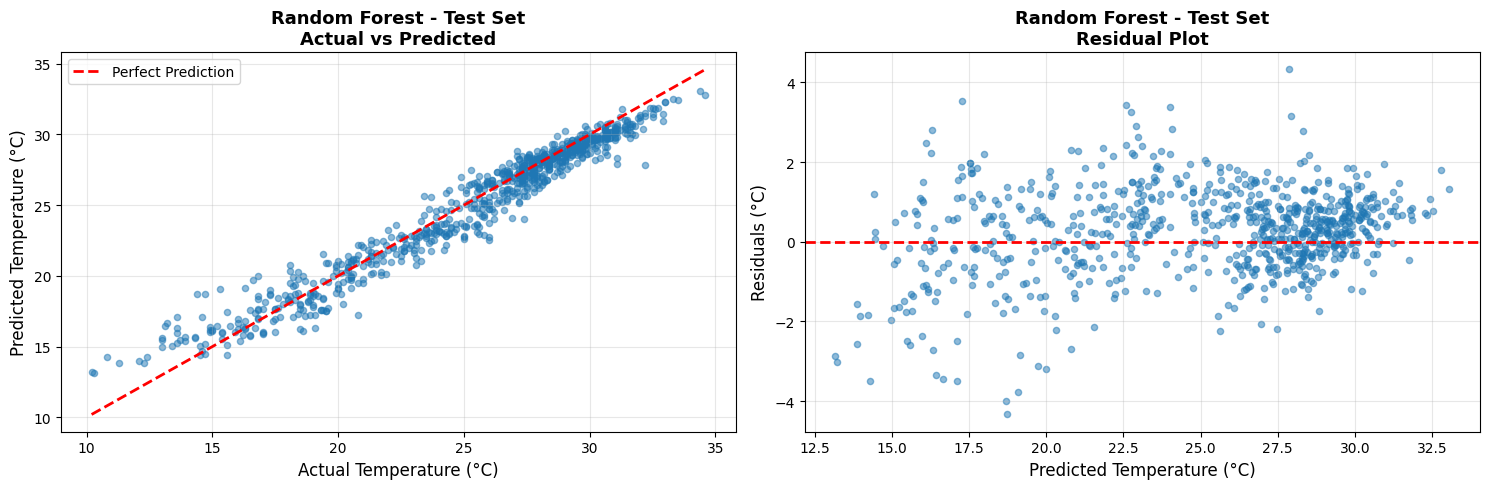


📊 Residual Statistics:
   Mean:   0.2598°C
   Std:    1.0975°C
   Min:    -4.3329°C
   Max:    4.3257°C


In [203]:
# ============================================
# 1. RANDOM FOREST
# ============================================

print("="*80)
print("🌲 TRAINING RANDOM FOREST")
print("="*80)

rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1,
    verbose=0
)

rf_results = train_and_evaluate_gbdt(
    model=rf_model,
    model_name="Random Forest",
    X_train=X_train_encoded,
    y_train=y_train_final,
    X_test=X_test_encoded,
    y_test=y_test_final,
    plot=True
)

In [204]:
# # ============================================
# # 2. GRADIENT BOOSTING (SKLEARN)
# # ============================================

# print("\n" + "="*80)
# print("📈 TRAINING GRADIENT BOOSTING (Sklearn)")
# print("="*80)

# gb_model = GradientBoostingRegressor(
#     n_estimators=200,
#     max_depth=6,
#     learning_rate=0.1,
#     subsample=0.8,
#     min_samples_split=5,
#     min_samples_leaf=2,
#     random_state=42,
#     verbose=0
# )

# gb_results = train_and_evaluate_gbdt(
#     model=gb_model,
#     model_name="Gradient Boosting",
#     X_train=X_train_final,
#     y_train=y_train_final,
#     X_test=X_test_final,
#     y_test=y_test_final,
#     plot=True
# )


🚀 TRAINING XGBOOST

🚀 TRAINING XGBoost
✅ Training completed in 0.78 seconds

📊 Train Performance:
   RMSE: 0.0722°C
   MAE:  0.0557°C
   R²:   0.9998
   MAPE: 0.24%

📊 Test Performance:
   RMSE: 0.4744°C
   MAE:  0.3291°C
   R²:   0.9911
   MAPE: 1.52%

🔍 OVERFITTING ANALYSIS - XGBoost

RMSE:
   Train: 0.0722
   Test:  0.4744
   Diff:  +0.4022 (+557.00%)

MAE:
   Train: 0.0557
   Test:  0.3291
   Diff:  +0.2734 (+490.88%)

R2:
   Train: 0.9998
   Test:  0.9911
   Diff:  +0.0087 (+0.87%)

MAPE:
   Train: 0.2397
   Test:  1.5202
   Diff:  +1.2806 (+534.30%)

⚠️  SEVERE OVERFITTING DETECTED


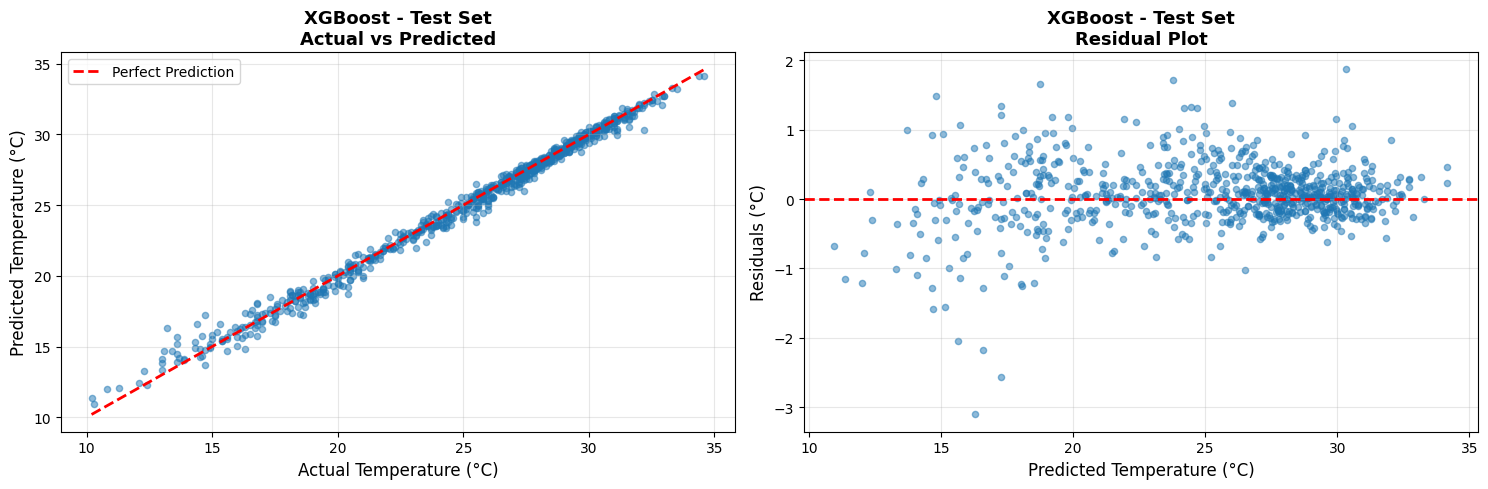


📊 Residual Statistics:
   Mean:   0.0725°C
   Std:    0.4691°C
   Min:    -3.1054°C
   Max:    1.8709°C


In [205]:
# ============================================
# 3. XGBOOST
# ============================================

print("\n" + "="*80)
print("🚀 TRAINING XGBOOST")
print("="*80)

xgb_model = xgb.XGBRegressor(
    n_estimators=200,
    max_depth=4,  # ✅ Giảm từ 6 → 4
    learning_rate=0.05,  # ✅ Giảm từ 0.1 → 0.05
    subsample=0.7,  # ✅ Giảm từ 0.8 → 0.7
    colsample_bytree=0.7,  # ✅ Giảm từ 0.8 → 0.7
    min_child_weight=5,  # ✅ Tăng từ 3 → 5
    gamma=0.1,  # ✅ Tăng từ 0 → 0.1
    reg_alpha=0.5,  # ✅ Tăng L1 regularization
    reg_lambda=2,  # ✅ Tăng L2 regularization
    random_state=42,
    n_jobs=-1,
    verbosity=0
)

xgb_results = train_and_evaluate_gbdt(
    model=xgb_model,
    model_name="XGBoost",
    X_train=X_train_encoded,
    y_train=y_train_final,
    X_test=X_test_encoded,
    y_test=y_test_final,
    plot=True
)


💡 TRAINING LIGHTGBM

🚀 TRAINING LightGBM
✅ Training completed in 0.51 seconds

📊 Train Performance:
   RMSE: 0.1371°C
   MAE:  0.1042°C
   R²:   0.9993
   MAPE: 0.46%

📊 Test Performance:
   RMSE: 0.4493°C
   MAE:  0.3195°C
   R²:   0.9920
   MAPE: 1.44%

🔍 OVERFITTING ANALYSIS - LightGBM

RMSE:
   Train: 0.1371
   Test:  0.4493
   Diff:  +0.3122 (+227.69%)

MAE:
   Train: 0.1042
   Test:  0.3195
   Diff:  +0.2153 (+206.59%)

R2:
   Train: 0.9993
   Test:  0.9920
   Diff:  +0.0073 (+0.73%)

MAPE:
   Train: 0.4601
   Test:  1.4373
   Diff:  +0.9772 (+212.37%)

⚠️  SEVERE OVERFITTING DETECTED


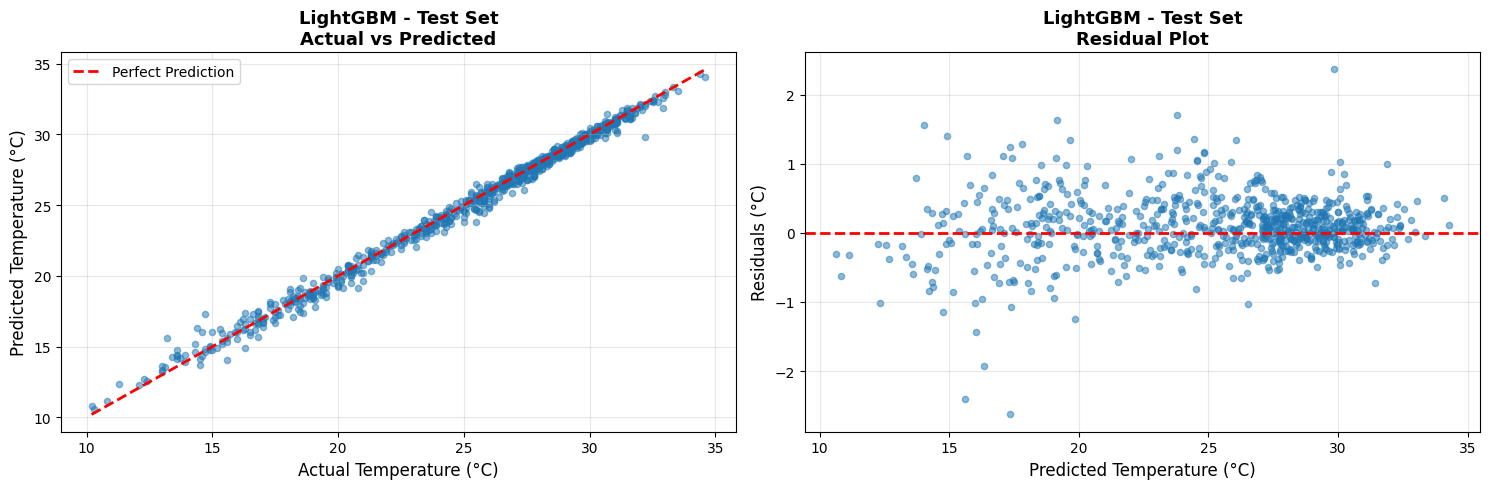


📊 Residual Statistics:
   Mean:   0.0850°C
   Std:    0.4415°C
   Min:    -2.6277°C
   Max:    2.3649°C


In [206]:
# ============================================
# 4. LIGHTGBM
# ============================================

print("\n" + "="*80)
print("💡 TRAINING LIGHTGBM")
print("="*80)

lgb_model = lgb.LGBMRegressor(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_samples=20,
    reg_alpha=0.1,
    reg_lambda=1,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

lgb_results = train_and_evaluate_gbdt(
    model=lgb_model,
    model_name="LightGBM",
    X_train=X_train_encoded,
    y_train=y_train_final,
    X_test=X_test_encoded,
    y_test=y_test_final,
    plot=True
)


🐱 TRAINING CATBOOST
📊 Categorical feature indices: [6]
   Columns: ['conditions']

🚀 TRAINING CatBoost
✅ Training completed in 9.23 seconds

📊 Train Performance:
   RMSE: 0.2454°C
   MAE:  0.1929°C
   R²:   0.9977
   MAPE: 0.84%

📊 Test Performance:
   RMSE: 0.3691°C
   MAE:  0.2697°C
   R²:   0.9946
   MAPE: 1.17%

🔍 OVERFITTING ANALYSIS - CatBoost

RMSE:
   Train: 0.2454
   Test:  0.3691
   Diff:  +0.1237 (+50.43%)

MAE:
   Train: 0.1929
   Test:  0.2697
   Diff:  +0.0768 (+39.82%)

R2:
   Train: 0.9977
   Test:  0.9946
   Diff:  +0.0031 (+0.31%)

MAPE:
   Train: 0.8356
   Test:  1.1655
   Diff:  +0.3299 (+39.48%)

⚠️  SEVERE OVERFITTING DETECTED


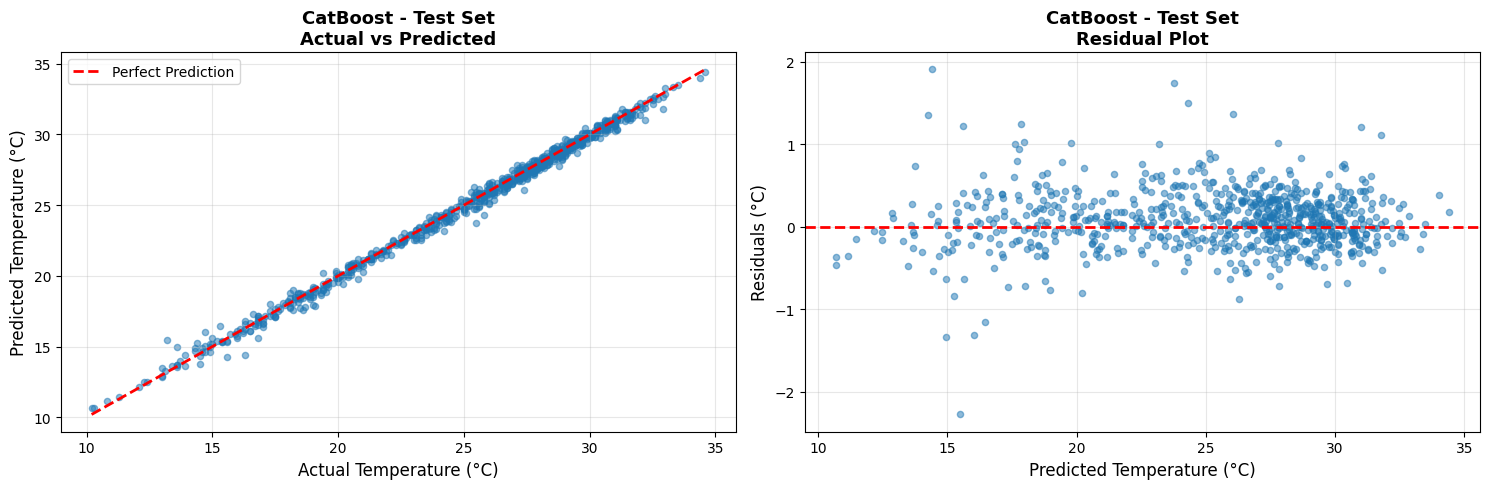


📊 Residual Statistics:
   Mean:   0.0819°C
   Std:    0.3601°C
   Min:    -2.2769°C
   Max:    1.9052°C


In [207]:
# ============================================
# 5. CATBOOST (FIXED)
# ============================================

print("\n" + "="*80)
print("🐱 TRAINING CATBOOST")
print("="*80)

from catboost import CatBoostRegressor

# 🔥 Tìm index của categorical features
cat_feature_indices = []
for i, col in enumerate(X_train_catboost.columns):
    if col == 'conditions':  # Hoặc kiểm tra dtype == 'object'
        cat_feature_indices.append(i)

print(f"📊 Categorical feature indices: {cat_feature_indices}")
print(f"   Columns: {[X_train_catboost.columns[i] for i in cat_feature_indices]}")

catboost_model = CatBoostRegressor(
    iterations=200,
    depth=6,
    learning_rate=0.1,
    subsample=0.8,
    l2_leaf_reg=3,
    cat_features=cat_feature_indices,
    random_state=42,
    verbose=0,
    thread_count=-1
)

catboost_results = train_and_evaluate_gbdt(
    model=catboost_model,
    model_name="CatBoost",
    X_train=X_train_catboost,
    y_train=y_train_final,
    X_test=X_test_catboost,
    y_test=y_test_final,
    plot=True
)

---
## 📊 MODEL COMPARISON


📊 MODEL COMPARISON SUMMARY

        Model  Train RMSE  Test RMSE  Train MAE  Test MAE  Train R²  Test R²  Train MAPE  Test MAPE  Training Time (s)
Random Forest    0.530138   1.127124   0.374570  0.874356  0.989427 0.949623    1.751857   3.898749           0.674638
      XGBoost    0.072204   0.474379   0.055703  0.329133  0.999804 0.991076    0.239672   1.520231           0.775040
     LightGBM    0.137116   0.449320   0.104214  0.319509  0.999293 0.991994    0.460127   1.437299           0.514196
     CatBoost    0.245370   0.369101   0.192921  0.269733  0.997735 0.994598    0.835567   1.165476           9.230441

🏆 BEST MODEL: CatBoost
   Test RMSE: 0.3691°C


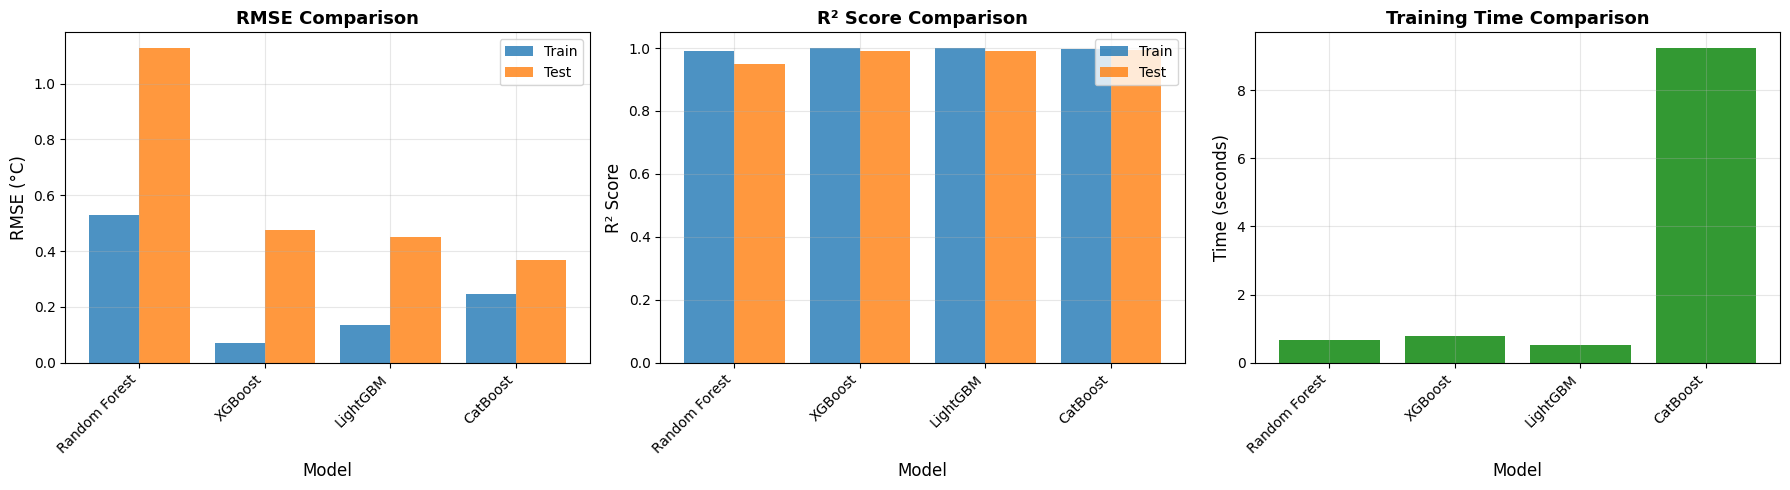

In [208]:
# ============================================
# SO SÁNH TẤT CẢ CÁC MÔ HÌNH
# ============================================

results_list = [rf_results, xgb_results, lgb_results, catboost_results]

comparison_df = compare_models(results_list)

In [209]:
# ============================================
# LƯU KẾT QUẢ SO SÁNH
# ============================================

# Export comparison table to CSV
comparison_df.to_csv('model_comparison_results.csv', index=False)
print("\n✅ Comparison results saved to 'model_comparison_results.csv'")

# Display detailed results
print("\n" + "="*80)
print("📋 DETAILED COMPARISON")
print("="*80)
print(comparison_df.to_string(index=False))


✅ Comparison results saved to 'model_comparison_results.csv'

📋 DETAILED COMPARISON
        Model  Train RMSE  Test RMSE  Train MAE  Test MAE  Train R²  Test R²  Train MAPE  Test MAPE  Training Time (s)
Random Forest    0.530138   1.127124   0.374570  0.874356  0.989427 0.949623    1.751857   3.898749           0.674638
      XGBoost    0.072204   0.474379   0.055703  0.329133  0.999804 0.991076    0.239672   1.520231           0.775040
     LightGBM    0.137116   0.449320   0.104214  0.319509  0.999293 0.991994    0.460127   1.437299           0.514196
     CatBoost    0.245370   0.369101   0.192921  0.269733  0.997735 0.994598    0.835567   1.165476           9.230441


---
## 🏆 FEATURE IMPORTANCE ANALYSIS

🏆 Analyzing feature importance for: CatBoost

📊 Top 20 Most Important Features:
                 feature  importance
                     dew   53.407992
                humidity   15.126031
          solarradiation    3.156441
            sunrise_hour    2.989496
is_summer_monsoon_season    2.454075
    is_transition_season    2.277859
                  season    2.091680
               month_sin    2.003666
                 day_cos    1.885818
              cloudcover    1.788751
summer_monsoon_intensity    1.775834
       day_length_change    1.363782
is_winter_monsoon_season    1.237178
          humidity_lag_1    1.098999
  humidity_seasonal_mean    1.044899
             is_overcast    0.783473
                  wind_v    0.537658
             sunset_hour    0.480400
       solar_declination    0.467562
               month_cos    0.463461


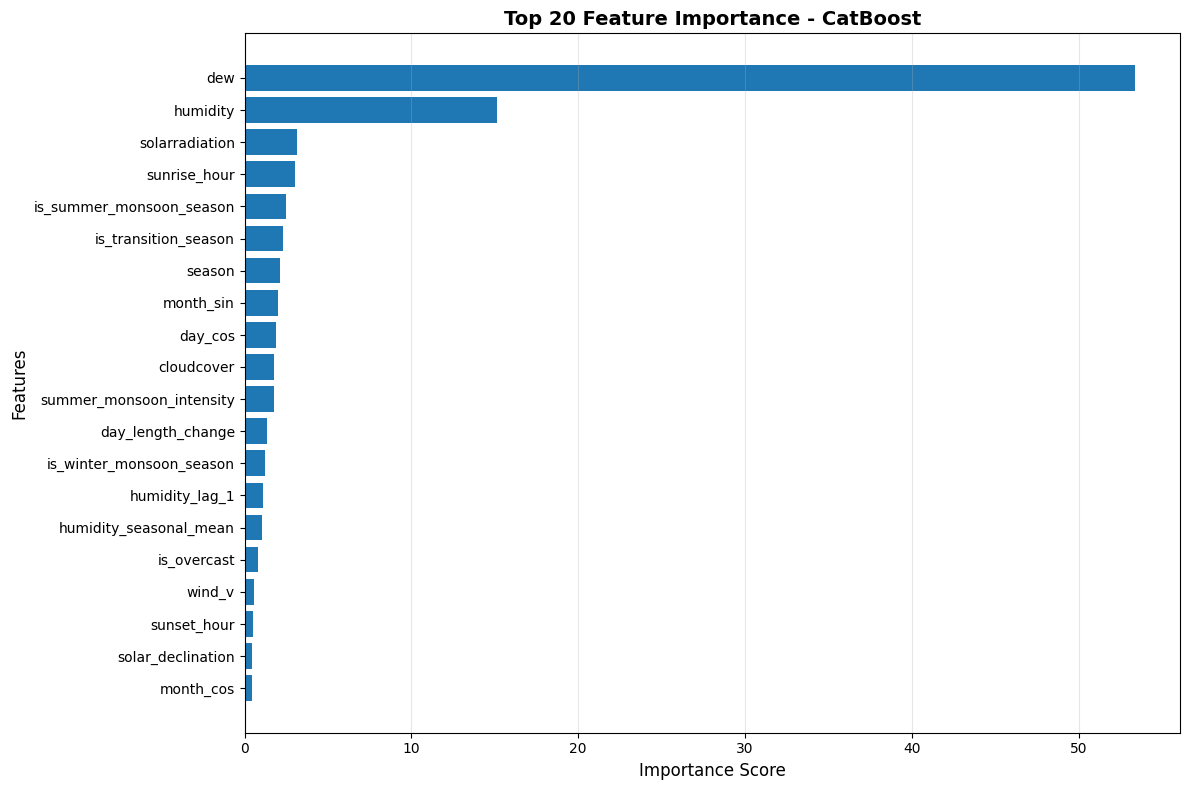


✅ Feature importance saved to 'feature_importance.csv'


In [210]:
# ============================================
# FEATURE IMPORTANCE - BEST MODEL
# ============================================

# Tìm mô hình tốt nhất
best_idx = comparison_df['Test RMSE'].idxmin()
best_model_name = comparison_df.loc[best_idx, 'Model']

print(f"🏆 Analyzing feature importance for: {best_model_name}")

# Lấy mô hình tốt nhất
best_result = results_list[best_idx]
best_model = best_result['model']

# Get feature importance
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': X_train_final.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(f"\n📊 Top 20 Most Important Features:")
    print(feature_importance.head(20).to_string(index=False))
    
    # Plot top 20 features
    plt.figure(figsize=(12, 8))
    top_features = feature_importance.head(20)
    plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Importance Score', fontsize=12)
    plt.ylabel('Features', fontsize=12)
    plt.title(f'Top 20 Feature Importance - {best_model_name}', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Save feature importance
    feature_importance.to_csv('feature_importance.csv', index=False)
    print(f"\n✅ Feature importance saved to 'feature_importance.csv'")
else:
    print("⚠️  Selected model does not have feature_importances_ attribute")

---
## 📈 FINAL SUMMARY

In [211]:
# ============================================
# FINAL SUMMARY
# ============================================

print("\n" + "="*80)
print("🎯 FINAL EXPERIMENT SUMMARY")
print("="*80)

print(f"\n📊 Dataset Information:")
print(f"   Training samples:   {X_train_final.shape[0]}")
print(f"   Testing samples:    {X_test_final.shape[0]}")
print(f"   Number of features: {X_train_final.shape[1]}")

print(f"\n🤖 Models Trained: {len(results_list)}")
for i, result in enumerate(results_list, 1):
    print(f"   {i}. {result['model_name']}")

print(f"\n🏆 Best Model: {best_model_name}")
print(f"   Test RMSE: {comparison_df.loc[best_idx, 'Test RMSE']:.4f}°C")
print(f"   Test MAE:  {comparison_df.loc[best_idx, 'Test MAE']:.4f}°C")
print(f"   Test R²:   {comparison_df.loc[best_idx, 'Test R²']:.4f}")
print(f"   Test MAPE: {comparison_df.loc[best_idx, 'Test MAPE']:.2f}%")

print(f"\n📁 Files Created:")
print(f"   ✓ model_comparison_results.csv")
print(f"   ✓ feature_importance.csv")

print("\n" + "="*80)
print("✅ EXPERIMENT COMPLETED SUCCESSFULLY!")
print("="*80)


🎯 FINAL EXPERIMENT SUMMARY

📊 Dataset Information:
   Training samples:   3045
   Testing samples:    780
   Number of features: 46

🤖 Models Trained: 4
   1. Random Forest
   2. XGBoost
   3. LightGBM
   4. CatBoost

🏆 Best Model: CatBoost
   Test RMSE: 0.3691°C
   Test MAE:  0.2697°C
   Test R²:   0.9946
   Test MAPE: 1.17%

📁 Files Created:
   ✓ model_comparison_results.csv
   ✓ feature_importance.csv

✅ EXPERIMENT COMPLETED SUCCESSFULLY!
